In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models
from matplotlib.patches import Rectangle
import csv

In [3]:
data_root = ".\\dataset"
print(os.listdir(data_root))

['test', 'train', 'train_data.csv']


In [4]:
train_dir = "train"
val_dir = "val"
class_names = ["d0_no", "d1_human"]

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dir, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        img = cv2.imread(os.path.join(source_dir, file_name), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        cv2.imwrite(os.path.join(dest_dir, file_name), img)

100%|██████████| 3/3 [00:00<00:00, 56.66it/s]


In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [6]:
xc = []
yc = []
w = []
h = []

with open(os.path.join(data_root, "train_data.csv"), 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        xc.append(float(row[1]))
        yc.append(float(row[2]))
        w.append(float(row[3]))
        h.append(float(row[4]))

In [108]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        if original_tuple[1] == 0:
            # tuple_new = (original_tuple + (-1, -1, -1, -1,))
            tuple_new = (original_tuple + (0.001, 0.001, 0.001, 0.001,))
        elif original_tuple[1] == 1:
            id = int(path.split("\\")[2].replace(".jpg", ""))
            tuple_new = (original_tuple + (xc[id], yc[id], w[id], h[id],))
        return tuple_new

# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         path = self.imgs[index][0]
#         if original_tuple[1] == 0:
#             tuple_new = (original_tuple[0], [original_tuple[1], 0.001, 0.001, 0.001, 0.001])
#         elif original_tuple[1] == 1:
#             id = int(path.split("\\")[2].replace(".jpg", ""))
#             tuple_new = (original_tuple[0], [original_tuple[1], xc[id], yc[id], w[id], h[id]])
#         return tuple_new

# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         return original_tuple

In [115]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageFolderWithPaths(train_dir, train_transforms)
val_dataset = ImageFolderWithPaths(val_dir, val_transforms)

print(train_dataset.samples)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

[('train\\d0_no\\1.jpg', 0), ('train\\d0_no\\2.jpg', 0), ('train\\d1_human\\1.jpg', 1), ('train\\d1_human\\2.jpg', 1)]


In [116]:
len(train_dataloader), len(train_dataset)

(1, 4)

In [117]:
def show_input(input_tensor, title='', num_batch=0, num_elem_batch=0):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    image = image.clip(0, 1)
    plt.imshow(image)
    rect = Rectangle((50, 50), 150, 150, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title(str(num_batch) + "." + str(num_elem_batch) + ") " + title)
    plt.show()
    plt.pause(0.001)

def show_input_all(dataloader):
    it = iter(dataloader)
    for i in range(len(dataloader)):
        X_batch, y_batch, xc_batch, yc_batch, w_batch, h_batch = next(it)
        # print("y_batch:", y_batch)
        print("y_batch:", y_batch.reshape(-1, 1))
        print("xc_batch:", xc_batch)
        print("yc_batch:", yc_batch)
        print("w_batch:", w_batch)
        print("h_batch:", h_batch)
        num_elem_batch = 0
        for x_item, y_item in zip(X_batch, y_batch):
            show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
            num_elem_batch += 1

# def show_input_all(dataloader):
#     it = iter(dataloader)
#     for i in range(len(dataloader)):
#         X_batch, list_batch = next(it)
#         print("list_batch:", list_batch)
#         num_elem_batch = 0

y_batch: tensor([[1],
        [0],
        [1],
        [0]])
xc_batch: tensor([0.4000, 0.0010, 0.9000, 0.0010], dtype=torch.float64)
yc_batch: tensor([0.8000, 0.0010, 0.2000, 0.0010], dtype=torch.float64)
w_batch: tensor([1.2000e+01, 1.0000e-03, 1.0000e+00, 1.0000e-03], dtype=torch.float64)
h_batch: tensor([1.5000e+01, 1.0000e-03, 3.0000e+00, 1.0000e-03], dtype=torch.float64)


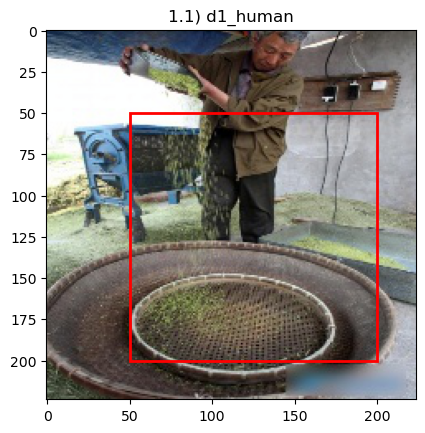

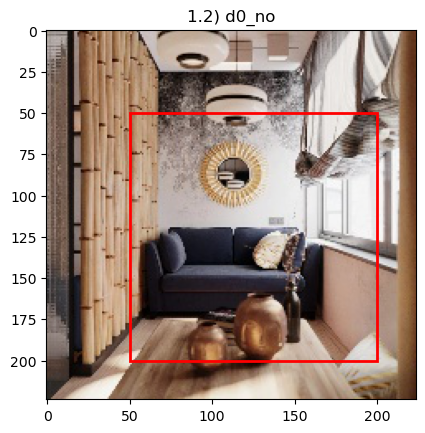

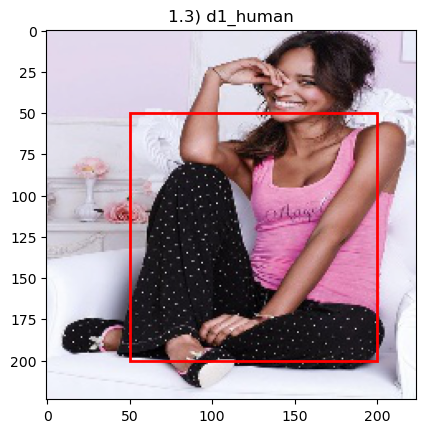

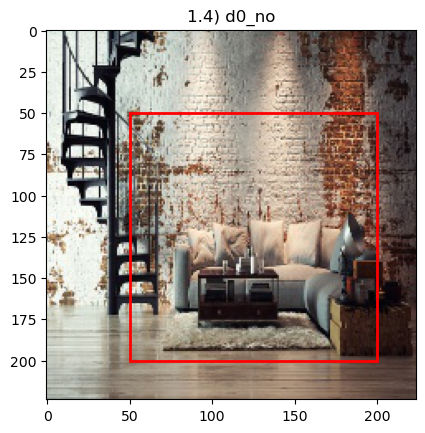

In [118]:
show_input_all(train_dataloader)

y_batch: tensor([[0],
        [1]])
xc_batch: tensor([0.0010, 0.3000], dtype=torch.float64)
yc_batch: tensor([0.0010, 0.6000], dtype=torch.float64)
w_batch: tensor([1.0000e-03, 7.0000e+00], dtype=torch.float64)
h_batch: tensor([1.0000e-03, 1.9000e+01], dtype=torch.float64)


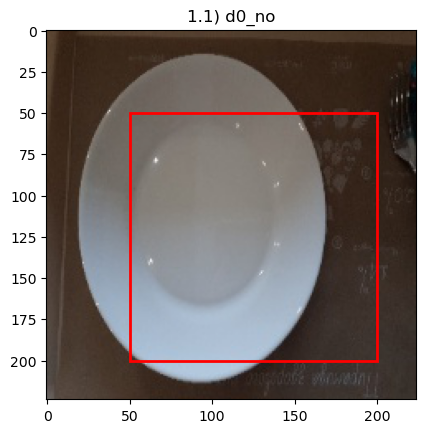

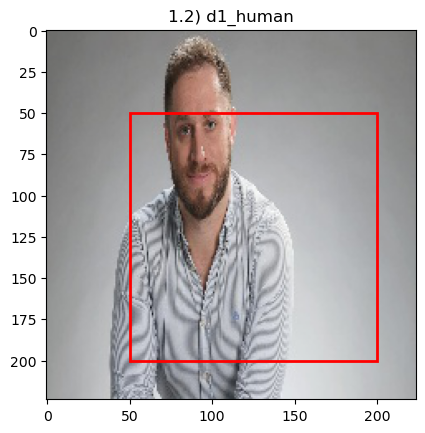

In [119]:
show_input_all(val_dataloader)

In [128]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

def train_model(model, sigmoid_act, bce_loss, mse_loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels, xcs, ycs, ws, hs in tqdm(dataloader):
                # inputs = inputs.to(device)
                # labels = labels.to(device)
                # xcs = xcs.to(device)
                # ycs = ycs.to(device)
                # ws = ws.to(device)
                # hs = hs.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)

                    labels = labels.reshape(-1, 1).float()
                    
                    term_labels = bce_loss(sigmoid_act(preds[:, 0:1]), labels)
                    term_xcs = bce_loss(sigmoid_act(preds[:, 1:2]), xcs.reshape(-1, 1).float())
                    term_ycs = bce_loss(sigmoid_act(preds[:, 2:3]), ycs.reshape(-1, 1).float())
                    term_ws = mse_loss(preds[:, 3:4], torch.log(ws.reshape(-1, 1).float()))
                    term_hs = mse_loss(preds[:, 4:5], torch.log(hs.reshape(-1, 1).float()))
                    
                    # loss_value = bce_loss(sigmoid_act(preds[:, 0:1]), labels.reshape(-1, 1).float()) + labels.reshape(-1, 1).float() * (bce_loss(sigmoid_act(preds[:, 1:2]), xcs.reshape(-1, 1)) + bce_loss(sigmoid_act(preds[:, 2:3]), ycs.reshape(-1, 1)) +
                    #                                                         mse_loss(preds[:, 3:4], torch.log(ws.reshape(-1, 1))) +
                    #                                                         mse_loss(preds[:, 4:5], torch.log(hs.reshape(-1, 1))))
                    loss_value = torch.sum(term_labels + labels * (term_xcs + term_ycs + term_ws + term_hs))
                    print(loss_value)
                    
                    # preds_class = preds.argmax(dim=1)
                    preds_class = torch.tensor([1 if pred.item() > 0.5 else 0 for pred in preds[:, 0:1]])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

    return model

In [129]:
# model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 5)

print(torch.cuda.is_available())

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if not torch.cuda.is_available() else "cpu")
print(device)
# model = model.to(device)

sigmoid_act = torch.nn.Sigmoid()

bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()

# optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)
# optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, fused=True, lr=1.0e-3)
# optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, foreach=False, fused=False, lr=1.0e-3)
# optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, foreach=False, lr=1.0e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

True
cpu


In [134]:
tmp = train_model(model, sigmoid_act, bce_loss, mse_loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

tensor(4.8741, grad_fn=<SumBackward0>)
train Loss: 4.8741 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 11.81it/s]

tensor(42.3963)
val Loss: 42.3963 Acc: 0.5000
Epoch 1/9:



100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

tensor(4.7817, grad_fn=<SumBackward0>)
train Loss: 4.7817 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 12.20it/s]

tensor(42.4740)
val Loss: 42.4740 Acc: 0.5000
Epoch 2/9:



100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

tensor(4.6968, grad_fn=<SumBackward0>)
train Loss: 4.6968 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 11.77it/s]

tensor(42.5389)
val Loss: 42.5389 Acc: 0.5000
Epoch 3/9:



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

tensor(4.6181, grad_fn=<SumBackward0>)
train Loss: 4.6181 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 11.61it/s]

tensor(42.5828)
val Loss: 42.5828 Acc: 0.5000
Epoch 4/9:



100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

tensor(4.5443, grad_fn=<SumBackward0>)
train Loss: 4.5443 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

tensor(42.5570)
val Loss: 42.5570 Acc: 0.5000
Epoch 5/9:



100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

tensor(4.5373, grad_fn=<SumBackward0>)
train Loss: 4.5373 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 14.06it/s]

tensor(42.5486)
val Loss: 42.5486 Acc: 0.5000
Epoch 6/9:



  0%|          | 0/1 [00:00<?, ?it/s]

tensor(4.5303, grad_fn=<SumBackward0>)


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

train Loss: 4.5303 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 13.82it/s]

tensor(42.5564)
val Loss: 42.5564 Acc: 0.5000
Epoch 7/9:



100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

tensor(4.5233, grad_fn=<SumBackward0>)
train Loss: 4.5233 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 13.14it/s]

tensor(42.5652)
val Loss: 42.5652 Acc: 0.5000
Epoch 8/9:



100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

tensor(4.5164, grad_fn=<SumBackward0>)
train Loss: 4.5164 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 13.52it/s]

tensor(42.5648)
val Loss: 42.5648 Acc: 0.5000
Epoch 9/9:



100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

tensor(4.5095, grad_fn=<SumBackward0>)
train Loss: 4.5095 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 12.47it/s]

tensor(42.5480)
val Loss: 42.5480 Acc: 0.5000


In [131]:
losses = {}
accuracies = {}

losses['train'], accuracies['train'] = train_loss_history, [elem.item() for elem in train_accuracy_history]
losses['val'], accuracies['val'] = val_loss_history, [elem.item() for elem in val_accuracy_history]

[98.9627685546875, 56.9224853515625, 33.639556884765625, 20.63138198852539, 13.289615631103516, 9.095187187194824, 6.662257671356201, 5.223372459411621, 5.091169357299805, 4.976198196411133]
[38.36256408691406, 47.62006378173828, 39.00190734863281, 44.883018493652344, 40.558441162109375, 43.873817443847656, 41.83026885986328, 42.053192138671875, 42.207786560058594, 42.29426574707031]


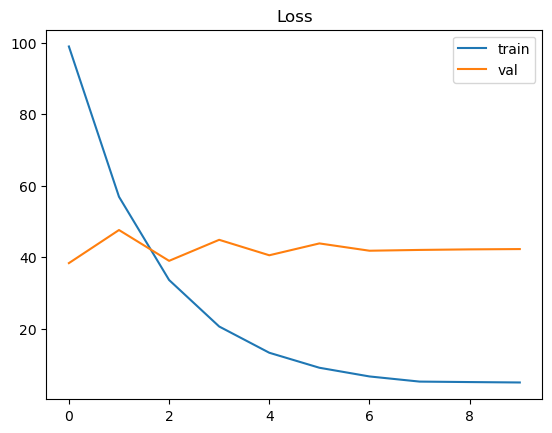

In [132]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Loss')
print(losses['train'])
print(losses['val'])

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


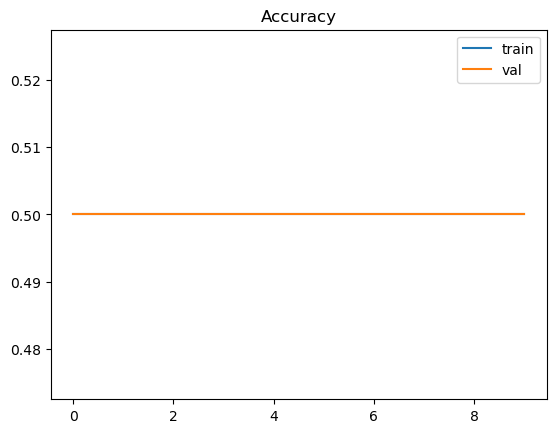

In [133]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Accuracy')
print(accuracies['train'])
print(accuracies['val'])

In [2]:
# !rm -rf train val test